# Imports

In [1]:
from utils import *
import matplotlib.gridspec as gridspec
import re
SEED = 0

# Parameters

In [2]:
# FPCA
N_BASIS = 15
N_COMPONENTS = 3

# WGAN
N_EPOCHS = 2000
N_CRITIC = 5
LAMBDA_GP = 0.5
BATCH_SIZE = 128
LATENT_DIM = 1
CONDITION_DIM = 1
INPUT_DIM = 1
G_HIDDEN_LAYERS = 4
G_HIDDEN_DIM = 16
G_LEAKY_RELU = 0.1
D_HIDDEN_LAYERS = 2
D_HIDDEN_DIM = 64
D_DROPOUT = 0.4
D_LEAKY_RELU = 0.1
LR_GEN = 0.0002
LR_DIS = 0.0002
B1 = 0.5
B2 = 0.999

In [3]:
def simplify_users(string):
  if re.search( pattern = 'mil', string = string.lower() ) is not None:
    return 'Military'
  if re.search( pattern = 'gov', string = string.lower() ) is not None:
    return 'Government'
  if re.search( pattern = 'com', string = string.lower() ) is not None:
    return 'Commercial'
  if re.search( pattern = 'civ', string = string.lower() ) is not None:
    return 'Civil'
  return string

# Data

## Loading & Inspection

In [4]:
data = pd.read_excel( 'UCS-Satellite-Database-5-1-2022.xls' )
data = data.iloc[:,:-39]
data.columns = [
    'name',
    'official_name',
    'country_reg',
    'country_op',
    'operator',
    'users',
    'purpose',
    'detailed_purpose',
    'orbit_class',
    'orbit_type',
    'GEO_long',
    'perigee',
    'apogee',
    'eccentricity',
    'inclination',
    'period',
    'launch_mass',
    'dry_mass',
    'power',
    'launch_date',
    'exp_lifetime',
    'contractor',
    'country_contr',
    'launch_site',
    'launch_vehicle',
    'cospar',
    'norad',
    'comments'
]

data.dropna(how='all', inplace=True)
data['norad'] = data.norad.apply(int).astype(str)
data['cospar_norad'] = data.norad + '-' + data.cospar
data.users = data.users.apply( simplify_users )
data['year'] = data['launch_date'].map(lambda fecha: fecha.year)

print(f'{(len(data))} observations')
print(f'First observation: {data.launch_date.min()}')
print(f'Last observation: {data.launch_date.max()}')

5465 observations
First observation: 1974-11-15 00:00:00
Last observation: 2022-04-29 00:00:00


In [5]:
# We first filter out registries for which we don't have their launch mass

print('We don\'t have the launch mass for {:.2f}% of the registries'.format( np.mean(data.launch_mass.isna())*100 ))
data = data[data.launch_mass.notna()].reset_index(drop=True)
print(f'{len(data)} observations')

We don't have the launch mass for 4.39% of the registries
5225 observations


In [6]:
dups = data.cospar_norad.duplicated().sum()
print(f'There are {dups} occurrences of duplications in cospar-norad ids. We drop them.')
data.drop_duplicates(subset='cospar_norad', inplace=True, ignore_index=True)

There are 2 occurrences of duplications in cospar-norad ids. We drop them.


In [7]:
# We restrict our dataset to a subgroup of satellites
# The main separation is by orbit type, with the most popular being LEO (low orbit) and GEO (geostationary orbit)
# LEO is the main group

data.groupby('orbit_class')['cospar_norad'].count() / data.shape[0]

orbit_class
Elliptical    0.010147
GEO           0.101474
LEO           0.861765
MEO           0.026613
Name: cospar_norad, dtype: float64

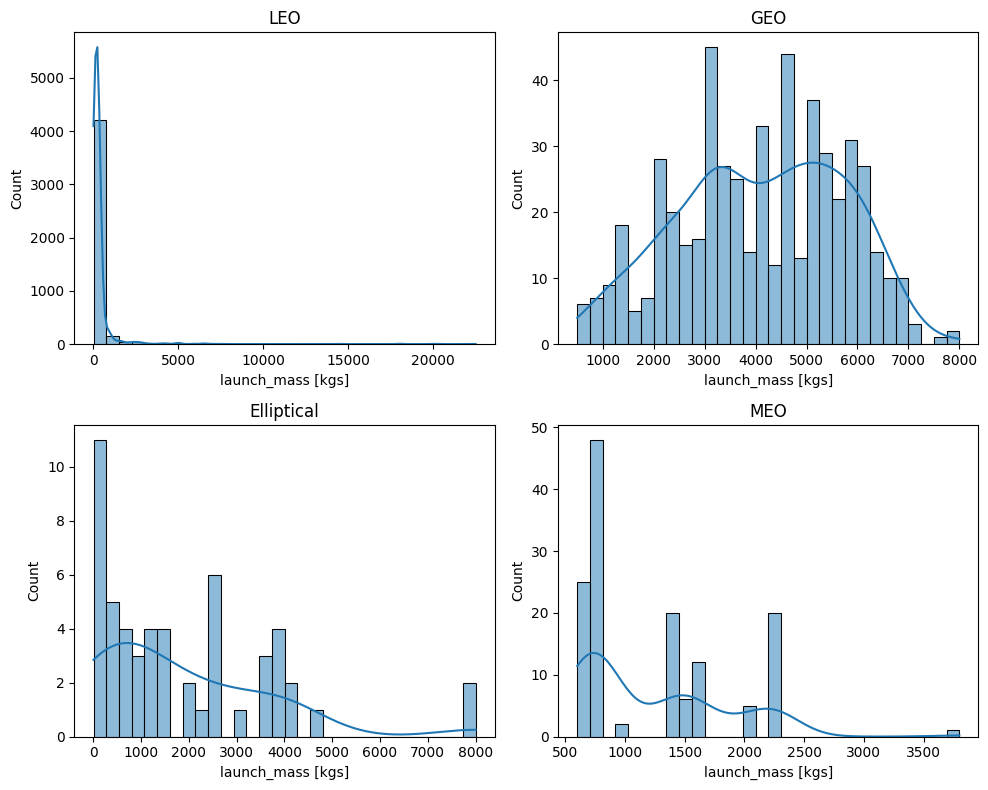

In [8]:
# The mass distribution varies for each of the orbit types. In general, within LEO satellites have a mass below 1000 kg
# GEO shows a different distribution with several satellites reaching up to 8 tons
# Being the most popular orbit type, we'll just keep LEO satellites

plt.figure(dpi=100, figsize=(10,8))
classes = pd.unique(data.orbit_class)

for i, orbit_class in zip( range(len(classes)), classes ):

  plt.subplot(2,2,i+1)
  sns.histplot(data[data.orbit_class == orbit_class].launch_mass, kde=True, bins=30)
  plt.xlabel('launch_mass [kgs]')
  plt.title(orbit_class)

plt.tight_layout()
plt.show()

In [9]:
data = data[data.orbit_class == 'LEO'].reset_index(drop=True)

In [10]:
# Only one observation is listed as 'Earth Observation' under the  user column (mistaking purpose with user)
# This is the BRIK-II satellitee, launched by the Dutch Air Force. We edit this observation.

data.loc[data.users == 'Earth Observation', 'users'] = 'Military'

In [11]:
# Per user analysis

data.groupby('users')['cospar_norad'].count()

users
Civil          145
Commercial    3689
Government     462
Military       205
Name: cospar_norad, dtype: int64

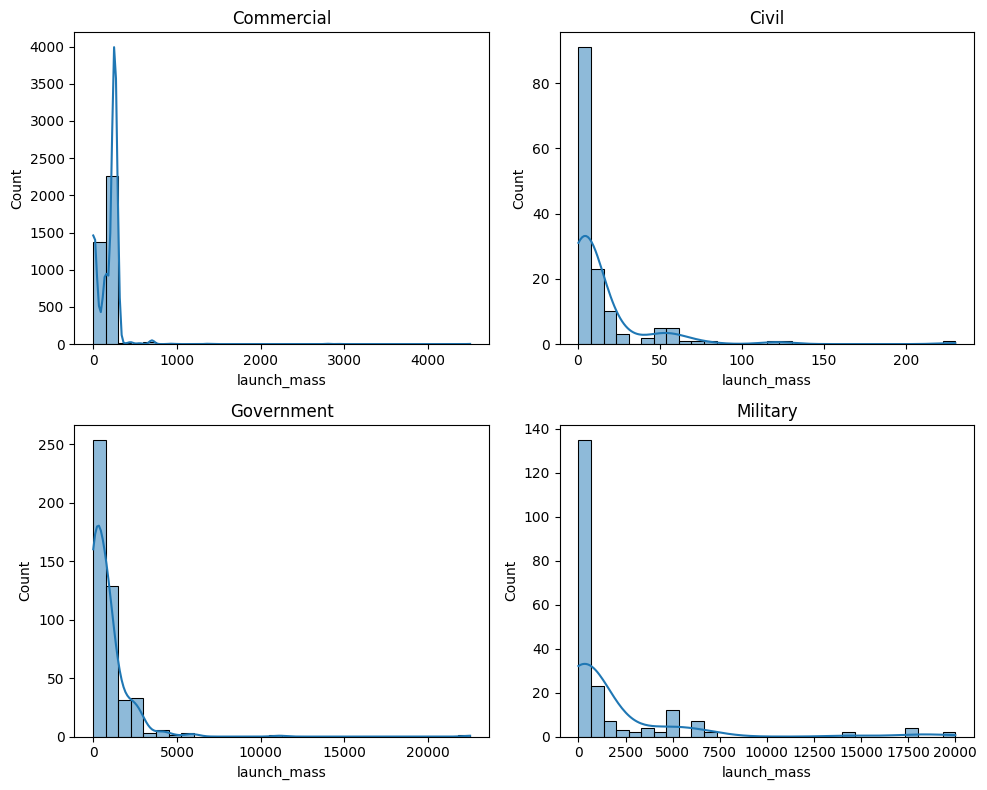

In [12]:
plt.figure(dpi=100, figsize=(10,8))
users = pd.unique(data.users)

for i, user in zip( range(len(users)), users ):

  plt.subplot(2,2,i+1)
  sns.histplot( data[data.users == user].launch_mass, bins=30, kde=True )
  plt.title(user)

plt.tight_layout()
plt.show()

In [13]:
# ALthough LEO comprises mainly light satellites, we see some heavy observations weighing several tons
# Focusing on this group, we note that all satellites above 4000 kg belong to military or governmental users

# We choose to discard observations above 4000 kg

print('{:.3f}% of LEO satellites weigh more than 4000 kg'.format(np.mean(data.launch_mass >= 4000)))
data.sort_values(by='launch_mass', ascending=False).head(5)

0.010% of LEO satellites weigh more than 4000 kg


name official_name   
4336                                            Tianhe        Tianhe   \
1146                                  NROL-86 (USA 326)       USA 326   
881   Keyhole 9 (NRO L82, Advanced KH-11, Evolved Im...       USA 314   
877   Keyhole 5 (Advanced KH-11, KH-12-5, Improved C...       USA 186   
878   Keyhole 6 (NRO L49, Advanced KH-11, KH-12-6, I...       USA 224   

     country_reg country_op                                       operator   
4336   NR (5/21)      China  China Manned Space Engineering Office (CMSEO)  \
1146   NR (4/22)        USA           National Reconnaissance Office (NRO)   
881          USA        USA           National Reconnaissance Office (NRO)   
877          USA        USA           National Reconnaissance Office (NRO)   
878          USA        USA           National Reconnaissance Office (NRO)   

           users            purpose detailed_purpose orbit_class   
4336  Government      Space Science              NaN         LEO  \
1146    Military  Earth Observation  Optical Imaging         LEO   
881     Military  Earth Observation  Optical Imaging         LEO   
877     Military  Earth Observation  Optical Imaging         LEO   
878     Military  Earth Observation  Optical Imaging         LEO   

              orbit_type  ...  exp_lifetime   
4336  Non-Polar Inclined  ...          15.0  \
1146     Sun-Synchronous  ...           NaN   
881      Sun-Synchronous  ...           5.0   
877           Elliptical  ...           5.0   
878           Elliptical  ...           5.0   

                                      contractor  country_contr   
4336  Chinese Academy of Space Technology (CAST)          China  \
1146                                     Unknown            USA   
881                              Lockheed Martin            USA   
877                              Lockheed Martin            USA   
878                              Lockheed Martin            USA   

                launch_site  launch_vehicle       cospar  norad   
4336  Wenchang Space Center   Long March 5B   2021-035A   48275  \
1146         Vandenberg AFB        Falcon 9    2022-009A  51445   
881          Vandenberg AFB   Delta 4 Heavy    2021-032A  48247   
877          Vandenberg AFB        Titan IV    2005-042A  28888   
878          Vandenberg AFB   Delta 4 Heavy    2011-002A  37348   

                                               comments       cospar_norad   
4336            First element of China's space station.  48275- 2021-035A   \
1146                                           Unknown.    51445-2022-009A   
881                L surveillance of satellites ca LEO.    48247-2021-032A   
877   $1 billion satellite; last use of Titan IV as ...    28888-2005-042A   
878                         Believed to be KH-11 class.    37348-2011-002A   

      year  
4336  2021  
1146  2022  
881   2021  
877   2005  
878   2011  

[5 rows x 30 columns]

In [14]:
data = data[data.launch_mass < 4000].reset_index(drop=True)

## Yearly grouping

We group LEO satellites below 4000 kg yearly

In [15]:
data = data[['launch_mass', 'year']].sort_values(by='year').reset_index(drop=True) # We just keep launch_mass and year of launch
print(data.groupby('year').launch_mass.count())

# As we seek to fit a distribution per year, we filter out years with few observations
# We chose to keep data from 2006 onwards, having at least 10 observations per year (which is still relatively few)
# Note that thee 2021-20222 drop is due to the fact that the dataset was published on May 2022

data = data[data.year >= 2006].reset_index(drop=True)

year
1974       1
1993       1
1997      10
1998      12
1999       9
2000       1
2001       7
2002       6
2003      10
2004      11
2005       5
2006      13
2007      27
2008      18
2009      24
2010      22
2011      37
2012      23
2013      48
2014      50
2015      73
2016      59
2017     179
2018     231
2019     229
2020    1052
2021    1611
2022     687
Name: launch_mass, dtype: int64


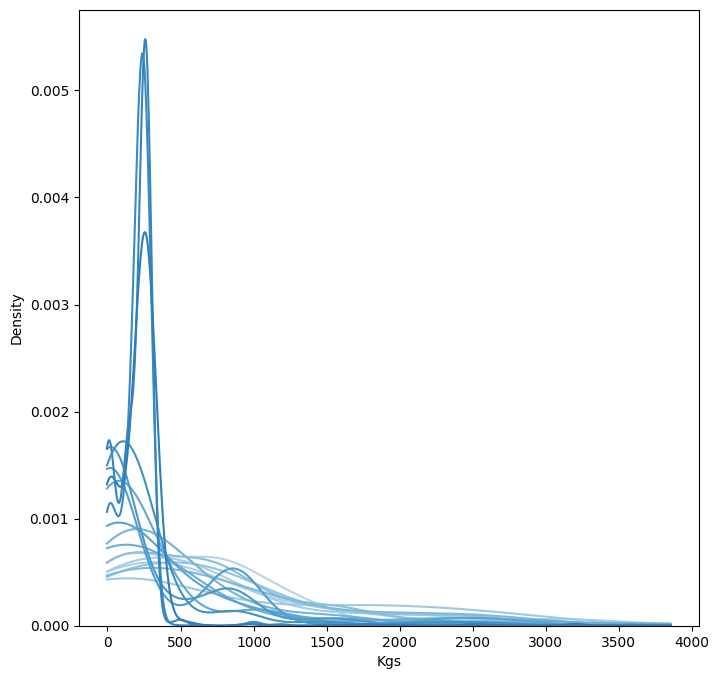

In [17]:
# We see a concentration towards the 200 kg mark for the last couple of years
# Judging by the densities, for the first years this concentracion was not so pronounced, with heavier satellites being more popular
# It's worth noting that the concentration we see for the last years is due to the launch of constellations like SpaceX's Starlink

# In a dataset of around 4400 obserrvations, almost half of it belongs to this constellation of practically idedntical satellites between 230 and 260 kgs, launched between 2019 and 2022

data_plot = data.copy()

kdes = get_kdes(data_plot, 'launch_mass', 'year', data_plot.year.unique())

# Evalúo las log-densidades sobre una grilla
grid_points = list(np.linspace(min(data_plot.launch_mass)-4, max(data_plot.launch_mass)+4, 1000))
data_matrix = [[kdes[t].score( np.array([[point]]) ) for point in grid_points] for t in data_plot.year.unique()]

plt.figure(dpi=100, figsize=(8,8))
for i, d in zip(np.linspace(0.3,0.7, len(data_matrix)), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kgs')
plt.show()

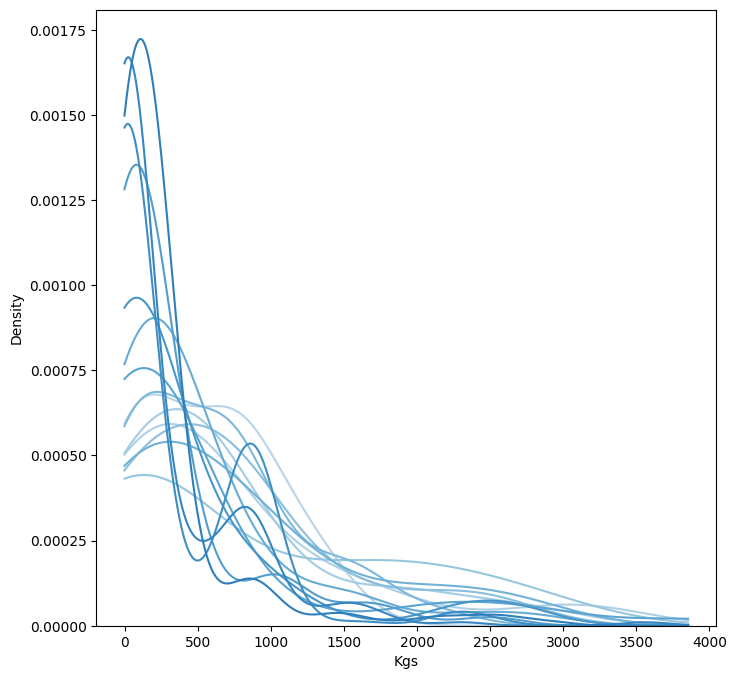

In [18]:
# Until 2019

plt.figure(dpi=100, figsize=(8,8))
for i, d in zip(np.linspace(0.3,0.7, len(data_matrix[:-3])), data_matrix[:-3]):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kgs')
plt.show()

# Forecasts
We now apply the three methods we presented to forecast the evolution of the densities
eWe'll fit all 3 models up until 2021, and we'll compare their predictions for 2022 against the actual distribution observed for that yearecha

In [19]:
data = data.rename(columns={'year':'time'})
VARS = ['launch_mass']
X_train = data[data.time < 2022].reset_index(drop=True)
X_test = data[data.time == 2022].reset_index(drop=True)
H_STEPS = 1
TIME_PERIODS = pd.unique(X_train.time)
FORECAST_PERIODS = np.arange(TIME_PERIODS[-1]+1, TIME_PERIODS[-1]+1+H_STEPS)

kdes = get_kdes(data, 'launch_mass', 'time', pd.unique(data.time))
    
# We evaluate the log-densities over a grid
grid_points = np.linspace(min(data.launch_mass)-4, max(data.launch_mass)+4, 1000)
data_matrix = [kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS]

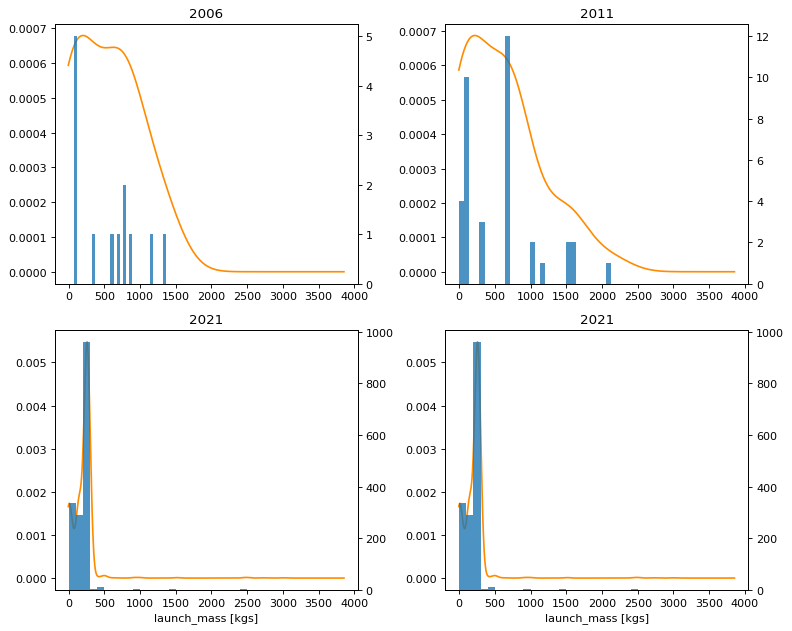

In [20]:
plt.figure(dpi=80, figsize=(10,8))

ax1 = plt.subplot(2,2,1)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[0]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[0]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[0])

ax1 = plt.subplot(2,2,2)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[5]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[5]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[5])

ax1 = plt.subplot(2,2,3)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[15]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[15]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
ax1.set_xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[15])

ax1 = plt.subplot(2,2,4)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[-1]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[-1]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
ax1.set_xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[-1])

plt.tight_layout()

plt.show()

## Parametric

We fit mixtures of two log-normals for each year

In [23]:
np.random.seed(SEED)
mixtures = Mixtures(X_train, vars=VARS, n_components=2, distributions=LogNormalDistribution)
mixtures.fit()
mixtures.forecast(steps=H_STEPS, predict=['mean','weight'])

/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without 

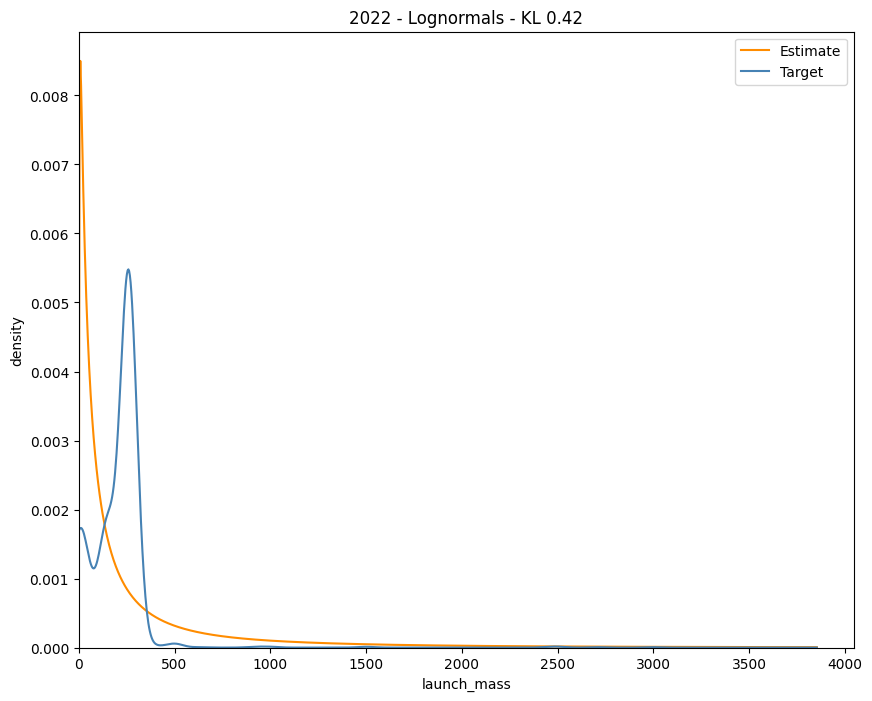

In [24]:
output_parametrico = np.exp(mixtures.new_mixtures[0].log_probability(grid_points))
KL_parametrico = get_kl( output_parametrico[1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, output_parametrico, 'darkorange', label='Estimate')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - Lognormals - KL {:.2f}'.format(KL_parametrico))


plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()

In [25]:
# We estimate the parameters for the test set

mix_test = Mixtures(X_test, vars=VARS, n_components=2, distributions=LogNormalDistribution)
mix_test.fit()

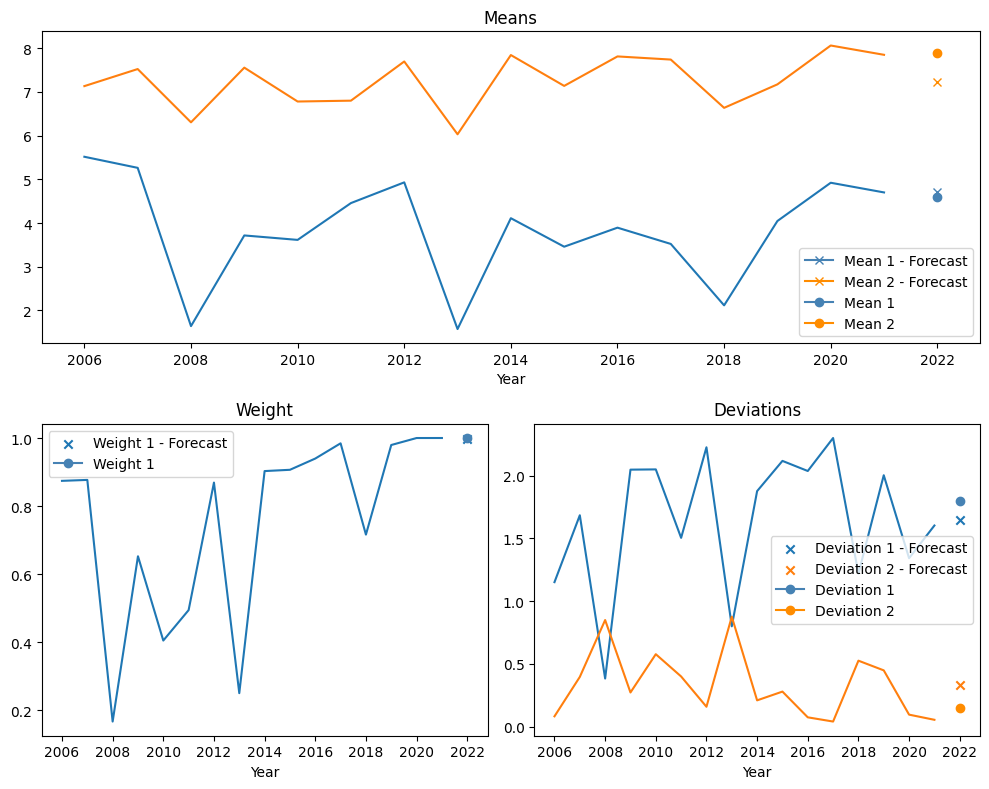

In [27]:
gs = gridspec.GridSpec(2, 2)

plt.figure(dpi=100, figsize=(10,8))

ax = plt.subplot(gs[0, :]) # row 0, col 0

plt.xlabel('Year')
plt.title('Means')
plt.plot(mixtures.means)
plt.plot(mixtures.pred_mean.m_0, 'steelblue', marker='x', label='Mean 1 - Forecast')
plt.plot(mixtures.pred_mean.m_1, 'darkorange', marker='x', label='Mean 2 - Forecast')

plt.plot(mix_test.means.m_0, 'steelblue', marker='o', label='Mean 1')
plt.plot(mix_test.means.m_1, 'darkorange', marker='o', label='Mean 2')
plt.tight_layout()
plt.legend()


ax = plt.subplot(gs[1, 0]) # row 0, col 1


plt.xlabel('Year')
plt.title('Weight')
plt.plot(mixtures.weights.w_0)

plt.scatter(FORECAST_PERIODS, mixtures.pred_weight.w_0, marker='x', label='Weight 1 - Forecast')
plt.plot(mix_test.weights.w_0, 'steelblue', marker='o', label='Weight 1')
plt.tight_layout()
plt.legend()


ax = plt.subplot(gs[1, 1]) # row 1, span all column

plt.xlabel('Year')
plt.title('Deviations')
plt.plot(mixtures.deviations)
plt.scatter(FORECAST_PERIODS, mixtures.pred_sd[0], marker='x', label='Deviation 1 - Forecast')
plt.scatter(FORECAST_PERIODS, mixtures.pred_sd[1], marker='x', label='Deviation 2 - Forecast')
plt.plot(mix_test.deviations.d_0, 'steelblue', marker='o', label='Deviation 1')
plt.plot(mix_test.deviations.d_1, 'darkorange', marker='o', label='Deviation 2')
plt.tight_layout()
plt.legend()

plt.show()


## FPCA

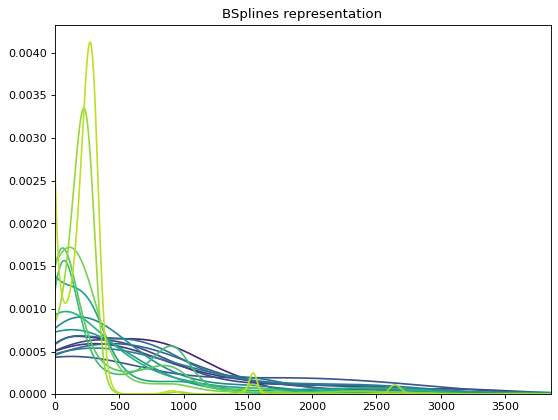

In [28]:
fpca_sats = Fpca(data_matrix, grid_points, n_basis=N_BASIS)

plt.figure(figsize=(8, 6), dpi=80)

for n, i in zip(np.linspace(0.1,0.9,len(TIME_PERIODS)), range(len(TIME_PERIODS))):
  plt.plot(grid_points, np.exp(fpca_sats.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))

plt.title('BSplines representation')
plt.xlim((grid_points[0], grid_points[-1]))
plt.gca().set_ylim(bottom=0)
plt.show()

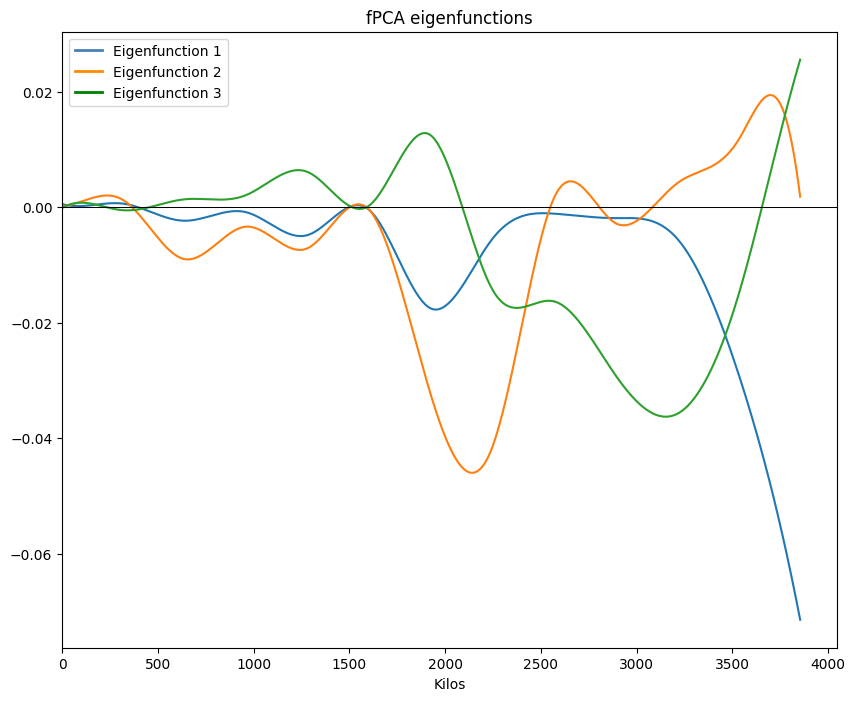

In [29]:

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]


fpca_sats.fit_fpca(N_COMPONENTS)

ax = plt.figure(dpi=100, figsize=(10,8))
fpca_sats.fpca.components_.plot(ax)
plt.title('fPCA eigenfunctions')
plt.axhline(0, color='black', linewidth=0.75)
plt.gca().set_xlim(left=0)
plt.legend(custom_lines, ['Eigenfunction 1', 'Eigenfunction 2', 'Eigenfunction 3'])

plt.xlabel('Kilos')

plt.show()



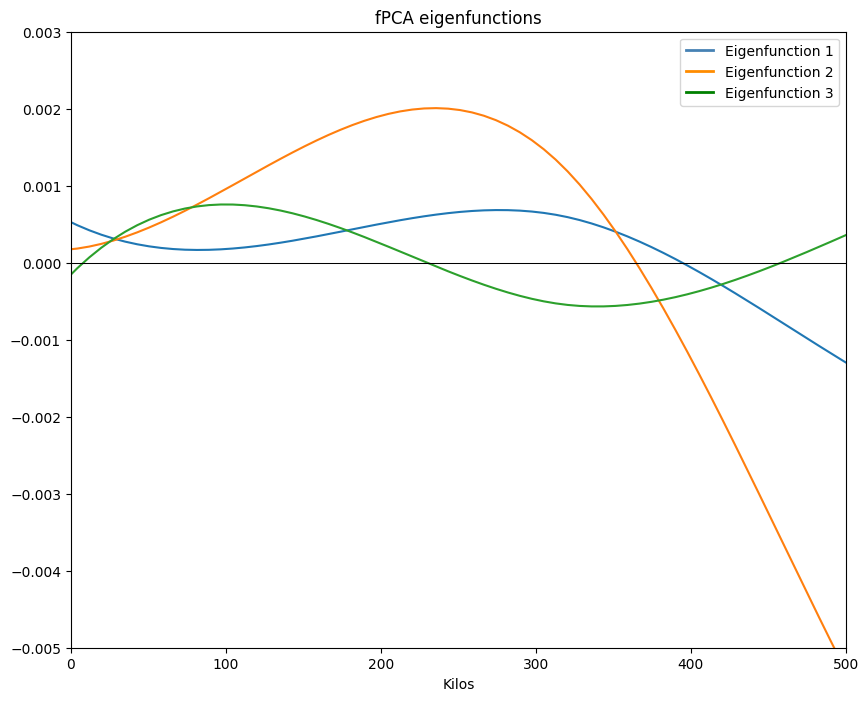

In [30]:

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]


fpca_sats.fit_fpca(N_COMPONENTS)

ax = plt.figure(dpi=100, figsize=(10,8))
fpca_sats.fpca.components_.plot(ax)
plt.title('fPCA eigenfunctions')
plt.axhline(0, color='black', linewidth=0.75)
plt.gca().set_xlim(left=0)
plt.legend(custom_lines, ['Eigenfunction 1', 'Eigenfunction 2', 'Eigenfunction 3'])
plt.xlim((0,500))
plt.ylim((-0.005,0.003))
plt.xlabel('Kilos')

plt.show()



In [31]:
print(fpca_sats.fpca.explained_variance_ratio_)
print(fpca_sats.fpca.explained_variance_ratio_.sum())

[0.89912488 0.06895226 0.02966234]
0.997739489394778


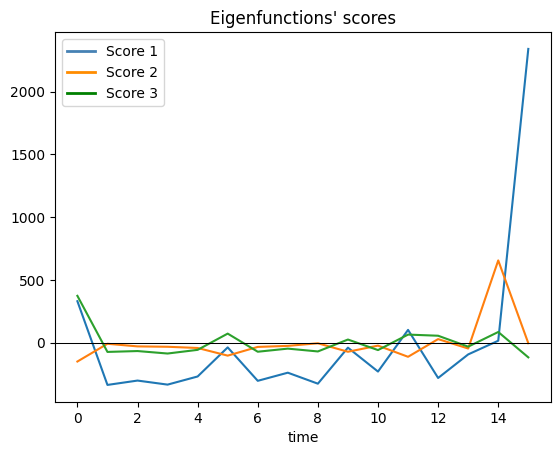

In [32]:

plt.plot(fpca_sats.scores)

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]

plt.title('Eigenfunctions\' scores')
plt.xlabel('time')
plt.axhline(0, color='black', linewidth=0.75)
plt.legend(custom_lines, ['Score 1', 'Score 2', 'Score 3'])
plt.show()

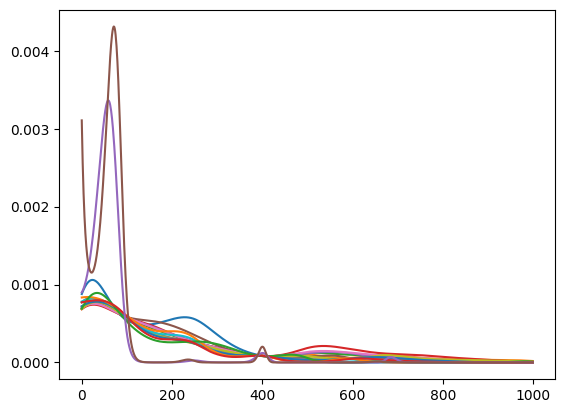

In [33]:
for i in range(len(TIME_PERIODS)):
  plt.plot(np.exp(fpca_sats.results[i]))
plt.show()

In [34]:
fpca_sats.fit_time_series(h_steps=H_STEPS)

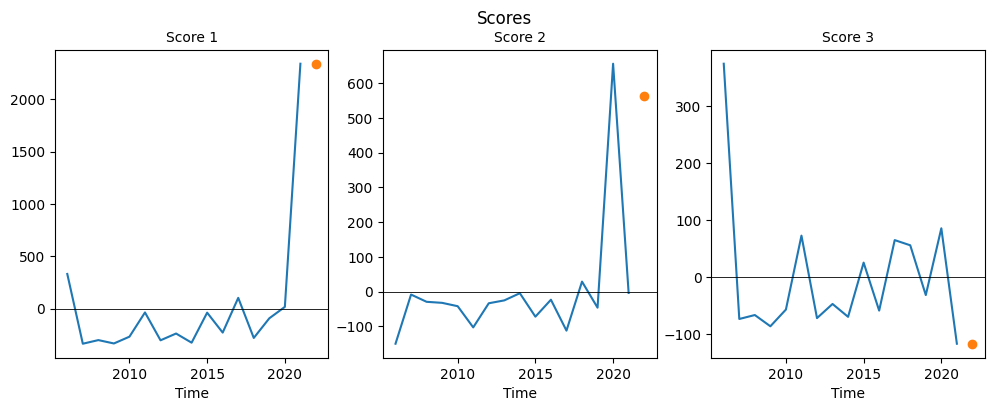

In [35]:
plt.figure(dpi=100, figsize=(12,4))

for i in range(N_COMPONENTS):
  plt.subplot(1,3,i+1)
  plt.plot(TIME_PERIODS, fpca_sats.scores[:,i])
  pred_plot = pd.DataFrame(fpca_sats.pred_w[:,i], index=FORECAST_PERIODS)
  plt.plot(pred_plot, marker='o')
  plt.axhline(0, color='black', linewidth=0.6)
  plt.title('Score {}'.format(i+1), fontsize=10)
  plt.xlabel('Time')

plt.suptitle('Scores')
plt.show()

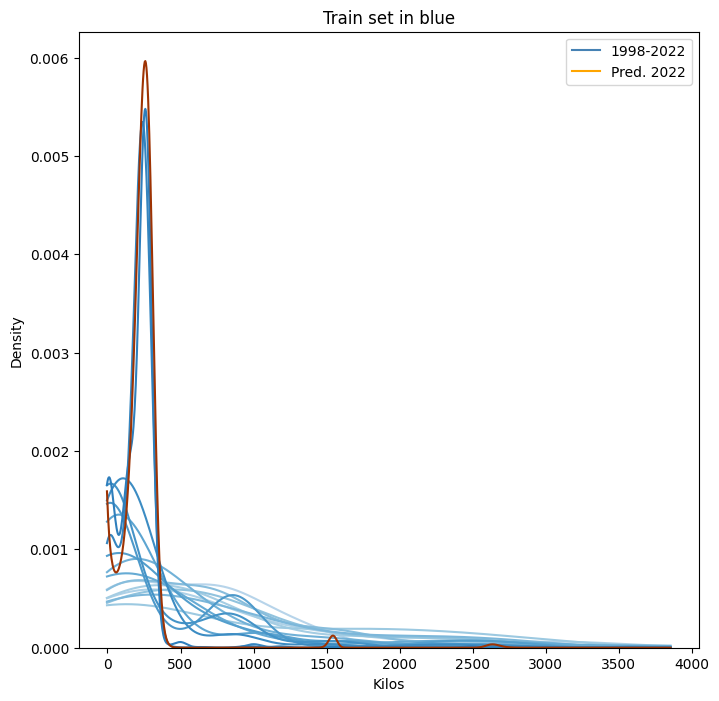

In [36]:
fpca_sats.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , len(TIME_PERIODS)), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

for i in fpca_sats.pred_f:
  plt.plot(grid_points, i, color=ORANGE(0.9))

kls_f = [get_kl( fpca_sats.pred_f[i][1:-1], np.exp(data_matrix[-1])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)
plt.xlabel('Time')
plt.title('Train set in blue')
plt.plot([], [], color='steelblue', label='1998-2022')
plt.plot([], [], color='orange', label='Pred. 2022')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kilos')
plt.legend()
plt.show()

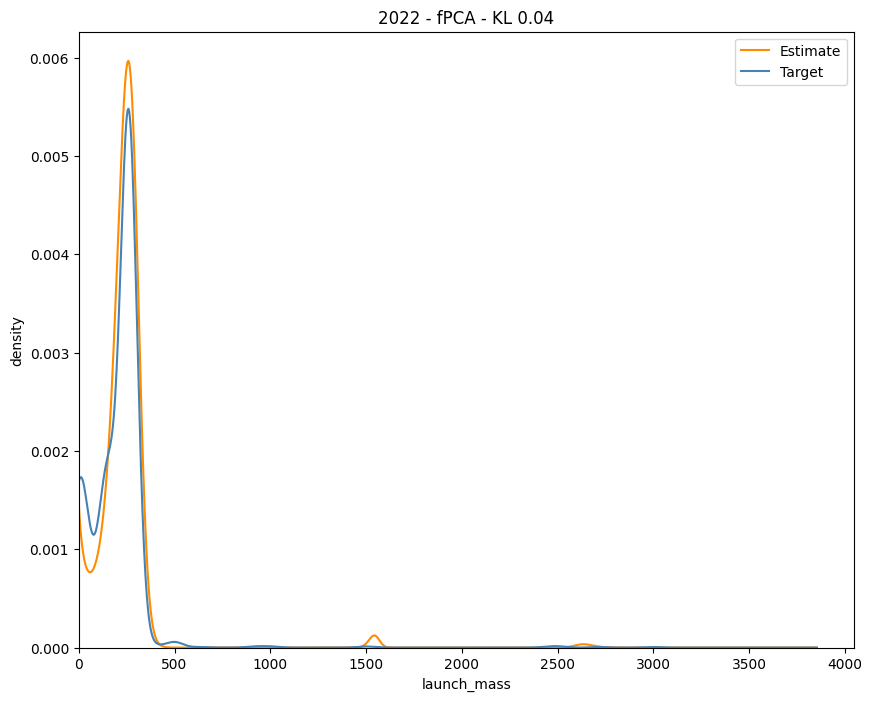

In [37]:
KL_fpca = get_kl( fpca_sats.pred_f[0][1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, fpca_sats.pred_f[0], 'darkorange', label='Estimate')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - fPCA - KL {:.2f}'.format(KL_fpca))

plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()

## WGAN

In [162]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_sats = Wgan(data = X_train,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

[0/2000]: loss_d: 0.472, loss_g: -0.470


2020.0


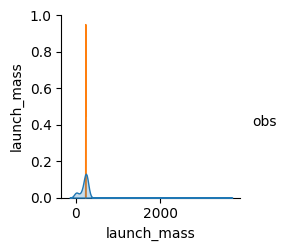

[10/2000]: loss_d: 0.069, loss_g: -0.355
[20/2000]: loss_d: 0.132, loss_g: -0.385
[30/2000]: loss_d: 0.267, loss_g: -0.442
[40/2000]: loss_d: 0.478, loss_g: -0.542
[50/2000]: loss_d: 0.525, loss_g: -0.589


2018.0


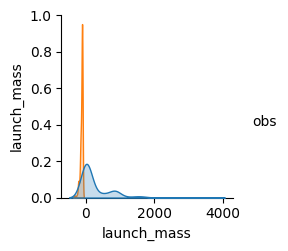

[60/2000]: loss_d: 0.530, loss_g: -0.560
[70/2000]: loss_d: 0.032, loss_g: -0.193
[80/2000]: loss_d: -0.286, loss_g: -0.169
[90/2000]: loss_d: -0.163, loss_g: -0.215
[100/2000]: loss_d: -0.046, loss_g: -0.294


2013.0


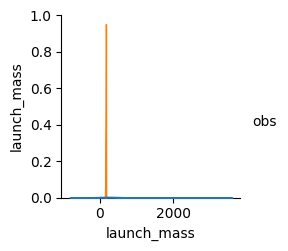

[110/2000]: loss_d: 0.158, loss_g: -0.358
[120/2000]: loss_d: 0.520, loss_g: -0.528
[130/2000]: loss_d: -0.155, loss_g: -0.159
[140/2000]: loss_d: -0.097, loss_g: -0.231
[150/2000]: loss_d: 0.060, loss_g: -0.263


2017.0


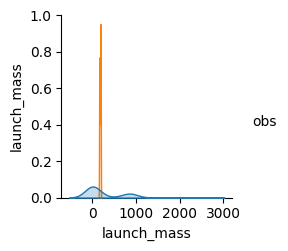

[160/2000]: loss_d: 0.174, loss_g: -0.307
[170/2000]: loss_d: 0.348, loss_g: -0.364
[180/2000]: loss_d: 0.492, loss_g: -0.286
[190/2000]: loss_d: 0.507, loss_g: -0.111
[200/2000]: loss_d: 0.135, loss_g: -0.095


2018.0


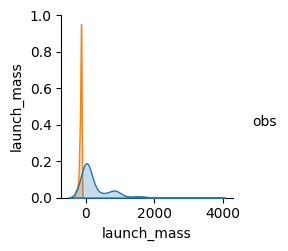

[210/2000]: loss_d: -0.341, loss_g: -0.181
[220/2000]: loss_d: -0.193, loss_g: -0.209
[230/2000]: loss_d: -0.072, loss_g: -0.284
[240/2000]: loss_d: 0.104, loss_g: -0.343
[250/2000]: loss_d: 0.402, loss_g: -0.523


2021.0


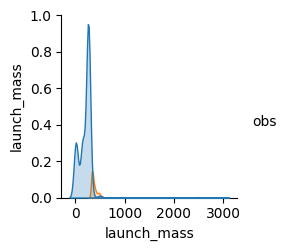

[260/2000]: loss_d: 0.486, loss_g: -0.568
[270/2000]: loss_d: -0.205, loss_g: -0.189
[280/2000]: loss_d: -0.048, loss_g: -0.386
[290/2000]: loss_d: 0.079, loss_g: -0.359
[300/2000]: loss_d: 0.188, loss_g: -0.408


2021.0


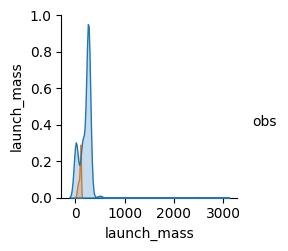

[310/2000]: loss_d: 0.131, loss_g: -0.469
[320/2000]: loss_d: -0.157, loss_g: -0.244
[330/2000]: loss_d: 0.123, loss_g: -0.437
[340/2000]: loss_d: 0.355, loss_g: -0.613
[350/2000]: loss_d: -0.089, loss_g: -0.238


2020.0


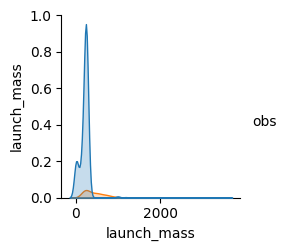

[360/2000]: loss_d: 0.073, loss_g: -0.437
[370/2000]: loss_d: 0.357, loss_g: -0.665
[380/2000]: loss_d: 0.522, loss_g: -0.730
[390/2000]: loss_d: 0.497, loss_g: -0.721
[400/2000]: loss_d: -0.166, loss_g: -0.358


2021.0


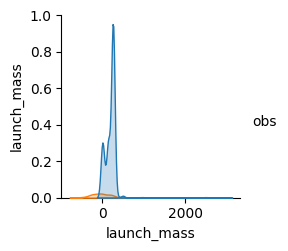

[410/2000]: loss_d: 0.081, loss_g: -0.581
[420/2000]: loss_d: 0.337, loss_g: -0.686
[430/2000]: loss_d: 0.094, loss_g: -0.354
[440/2000]: loss_d: 0.183, loss_g: -0.471
[450/2000]: loss_d: 0.225, loss_g: -0.503


2018.0


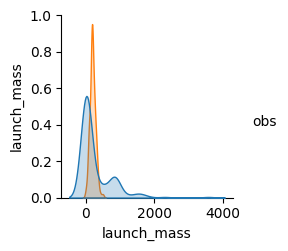

[460/2000]: loss_d: 0.180, loss_g: -0.473
[470/2000]: loss_d: 0.237, loss_g: -0.413
[480/2000]: loss_d: 0.195, loss_g: -0.341
[490/2000]: loss_d: 0.124, loss_g: -0.425
[500/2000]: loss_d: 0.115, loss_g: -0.459


2021.0


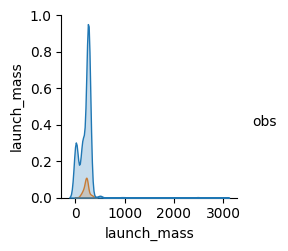

[510/2000]: loss_d: 0.117, loss_g: -0.448
[520/2000]: loss_d: 0.136, loss_g: -0.501
[530/2000]: loss_d: 0.150, loss_g: -0.498
[540/2000]: loss_d: 0.129, loss_g: -0.487
[550/2000]: loss_d: 0.120, loss_g: -0.460


2021.0


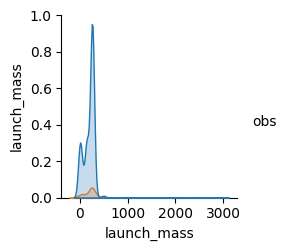

[560/2000]: loss_d: 0.120, loss_g: -0.470
[570/2000]: loss_d: 0.115, loss_g: -0.461
[580/2000]: loss_d: 0.108, loss_g: -0.448
[590/2000]: loss_d: 0.114, loss_g: -0.465
[600/2000]: loss_d: 0.112, loss_g: -0.483


2021.0


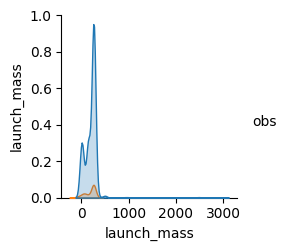

[610/2000]: loss_d: 0.117, loss_g: -0.467
[620/2000]: loss_d: 0.114, loss_g: -0.463
[630/2000]: loss_d: 0.121, loss_g: -0.467
[640/2000]: loss_d: 0.114, loss_g: -0.480
[650/2000]: loss_d: 0.122, loss_g: -0.464


2021.0


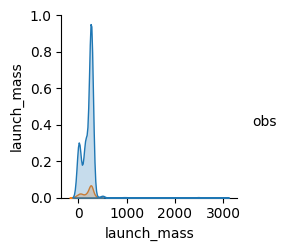

[660/2000]: loss_d: 0.124, loss_g: -0.482
[670/2000]: loss_d: 0.152, loss_g: -0.501
[680/2000]: loss_d: 0.157, loss_g: -0.504
[690/2000]: loss_d: 0.160, loss_g: -0.513
[700/2000]: loss_d: 0.151, loss_g: -0.483


2021.0


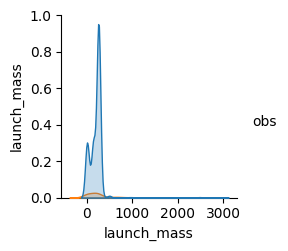

[710/2000]: loss_d: 0.154, loss_g: -0.514
[720/2000]: loss_d: 0.153, loss_g: -0.499
[730/2000]: loss_d: 0.156, loss_g: -0.511
[740/2000]: loss_d: 0.174, loss_g: -0.548
[750/2000]: loss_d: 0.160, loss_g: -0.538


2020.0


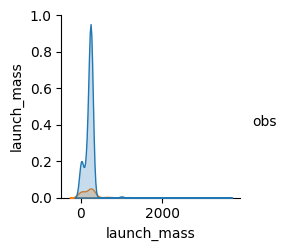

[760/2000]: loss_d: 0.165, loss_g: -0.504
[770/2000]: loss_d: 0.167, loss_g: -0.524
[780/2000]: loss_d: 0.180, loss_g: -0.542
[790/2000]: loss_d: 0.176, loss_g: -0.504
[800/2000]: loss_d: 0.167, loss_g: -0.497


2021.0


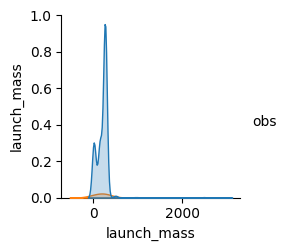

[810/2000]: loss_d: 0.164, loss_g: -0.528
[820/2000]: loss_d: 0.159, loss_g: -0.531
[830/2000]: loss_d: 0.173, loss_g: -0.524
[840/2000]: loss_d: 0.178, loss_g: -0.544
[850/2000]: loss_d: 0.172, loss_g: -0.528


2020.0


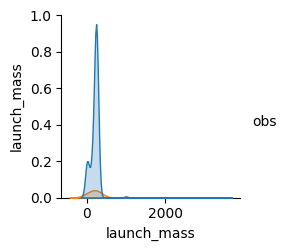

[860/2000]: loss_d: 0.165, loss_g: -0.497
[870/2000]: loss_d: 0.165, loss_g: -0.496
[880/2000]: loss_d: 0.157, loss_g: -0.503
[890/2000]: loss_d: 0.160, loss_g: -0.518
[900/2000]: loss_d: 0.161, loss_g: -0.488


2020.0


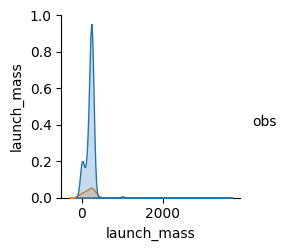

[910/2000]: loss_d: 0.155, loss_g: -0.504
[920/2000]: loss_d: 0.154, loss_g: -0.494
[930/2000]: loss_d: 0.152, loss_g: -0.497
[940/2000]: loss_d: 0.146, loss_g: -0.474
[950/2000]: loss_d: 0.148, loss_g: -0.497


2020.0


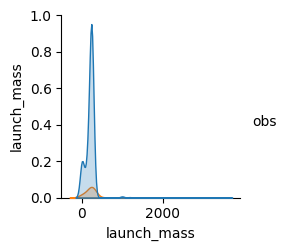

[960/2000]: loss_d: 0.137, loss_g: -0.512
[970/2000]: loss_d: 0.144, loss_g: -0.527
[980/2000]: loss_d: 0.145, loss_g: -0.511
[990/2000]: loss_d: 0.151, loss_g: -0.559
[1000/2000]: loss_d: 0.155, loss_g: -0.566


2020.0


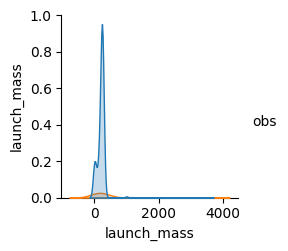

[1010/2000]: loss_d: 0.161, loss_g: -0.592
[1020/2000]: loss_d: 0.162, loss_g: -0.596
[1030/2000]: loss_d: 0.167, loss_g: -0.593
[1040/2000]: loss_d: 0.172, loss_g: -0.606
[1050/2000]: loss_d: 0.183, loss_g: -0.586


2020.0


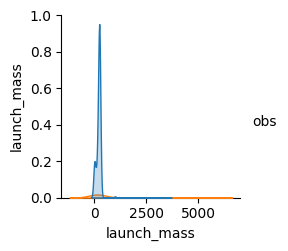

[1060/2000]: loss_d: 0.147, loss_g: -0.541
[1070/2000]: loss_d: 0.133, loss_g: -0.513
[1080/2000]: loss_d: 0.134, loss_g: -0.510
[1090/2000]: loss_d: 0.113, loss_g: -0.491
[1100/2000]: loss_d: 0.117, loss_g: -0.491


2017.0


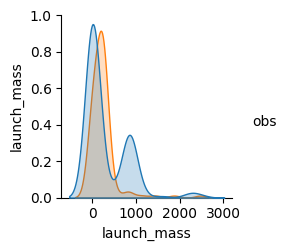

[1110/2000]: loss_d: 0.138, loss_g: -0.489
[1120/2000]: loss_d: 0.146, loss_g: -0.483
[1130/2000]: loss_d: 0.146, loss_g: -0.476
[1140/2000]: loss_d: 0.146, loss_g: -0.498
[1150/2000]: loss_d: 0.149, loss_g: -0.522


2020.0


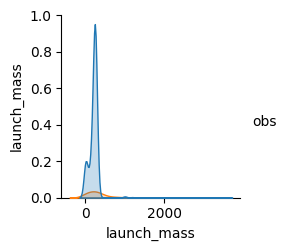

[1160/2000]: loss_d: 0.159, loss_g: -0.500
[1170/2000]: loss_d: 0.145, loss_g: -0.510
[1180/2000]: loss_d: 0.176, loss_g: -0.538
[1190/2000]: loss_d: 0.157, loss_g: -0.526
[1200/2000]: loss_d: 0.148, loss_g: -0.540


2020.0


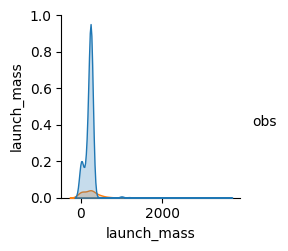

[1210/2000]: loss_d: 0.153, loss_g: -0.522
[1220/2000]: loss_d: 0.153, loss_g: -0.516
[1230/2000]: loss_d: 0.149, loss_g: -0.503
[1240/2000]: loss_d: 0.132, loss_g: -0.514
[1250/2000]: loss_d: 0.133, loss_g: -0.474


2020.0


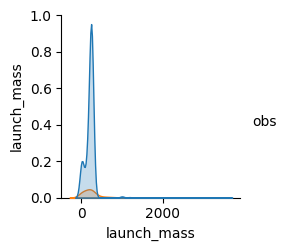

[1260/2000]: loss_d: 0.153, loss_g: -0.463
[1270/2000]: loss_d: 0.149, loss_g: -0.499
[1280/2000]: loss_d: 0.138, loss_g: -0.488
[1290/2000]: loss_d: 0.141, loss_g: -0.493
[1300/2000]: loss_d: 0.141, loss_g: -0.477


2018.0


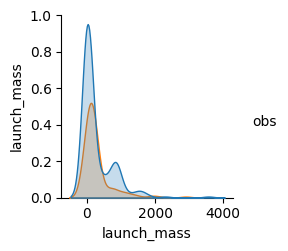

[1310/2000]: loss_d: 0.137, loss_g: -0.479
[1320/2000]: loss_d: 0.148, loss_g: -0.494
[1330/2000]: loss_d: 0.132, loss_g: -0.490
[1340/2000]: loss_d: 0.140, loss_g: -0.500
[1350/2000]: loss_d: 0.139, loss_g: -0.520


2019.0


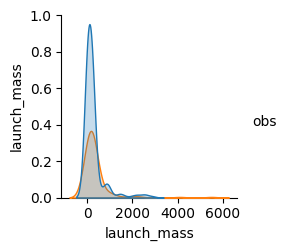

[1360/2000]: loss_d: 0.140, loss_g: -0.522
[1370/2000]: loss_d: 0.144, loss_g: -0.515
[1380/2000]: loss_d: 0.145, loss_g: -0.526
[1390/2000]: loss_d: 0.138, loss_g: -0.534
[1400/2000]: loss_d: 0.153, loss_g: -0.555


2021.0


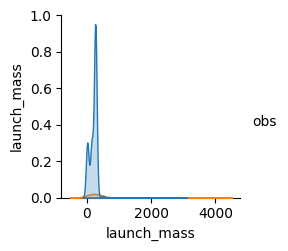

[1410/2000]: loss_d: 0.148, loss_g: -0.557
[1420/2000]: loss_d: 0.142, loss_g: -0.539
[1430/2000]: loss_d: 0.126, loss_g: -0.518
[1440/2000]: loss_d: 0.127, loss_g: -0.533
[1450/2000]: loss_d: 0.126, loss_g: -0.536


2020.0


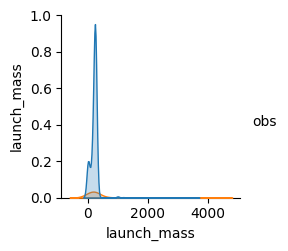

[1460/2000]: loss_d: 0.135, loss_g: -0.544
[1470/2000]: loss_d: 0.138, loss_g: -0.541
[1480/2000]: loss_d: 0.142, loss_g: -0.539
[1490/2000]: loss_d: 0.143, loss_g: -0.539
[1500/2000]: loss_d: 0.335, loss_g: -0.781


2021.0


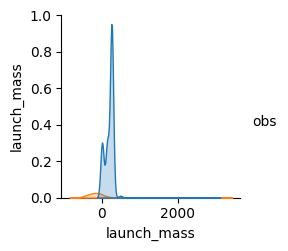

[1510/2000]: loss_d: 0.184, loss_g: -0.419
[1520/2000]: loss_d: 0.326, loss_g: -0.395
[1530/2000]: loss_d: 0.216, loss_g: -0.523
[1540/2000]: loss_d: 0.037, loss_g: -0.439
[1550/2000]: loss_d: 0.169, loss_g: -0.651


2020.0


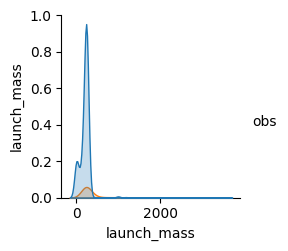

[1560/2000]: loss_d: 0.202, loss_g: -0.540
[1570/2000]: loss_d: 0.164, loss_g: -0.556
[1580/2000]: loss_d: 0.093, loss_g: -0.502
[1590/2000]: loss_d: 0.089, loss_g: -0.508
[1600/2000]: loss_d: 0.080, loss_g: -0.523


2021.0


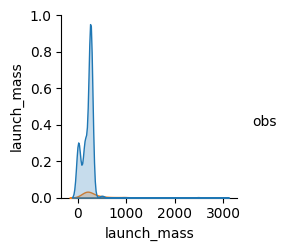

[1610/2000]: loss_d: 0.147, loss_g: -0.599
[1620/2000]: loss_d: 0.122, loss_g: -0.527
[1630/2000]: loss_d: 0.209, loss_g: -0.698
[1640/2000]: loss_d: 0.109, loss_g: -0.553
[1650/2000]: loss_d: 0.225, loss_g: -0.630


2021.0


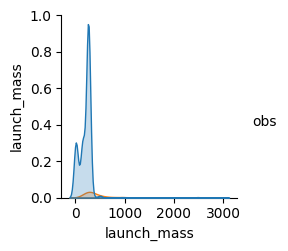

[1660/2000]: loss_d: 0.090, loss_g: -0.498
[1670/2000]: loss_d: 0.185, loss_g: -0.657
[1680/2000]: loss_d: 0.110, loss_g: -0.486
[1690/2000]: loss_d: 0.167, loss_g: -0.588
[1700/2000]: loss_d: 0.110, loss_g: -0.514


2021.0


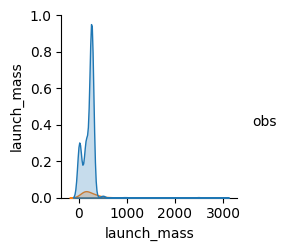

[1710/2000]: loss_d: 0.189, loss_g: -0.669
[1720/2000]: loss_d: 0.081, loss_g: -0.467
[1730/2000]: loss_d: 0.178, loss_g: -0.616
[1740/2000]: loss_d: 0.118, loss_g: -0.522
[1750/2000]: loss_d: 0.207, loss_g: -0.668


2020.0


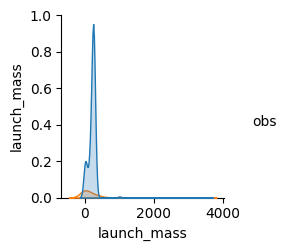

[1760/2000]: loss_d: 0.084, loss_g: -0.540
[1770/2000]: loss_d: 0.115, loss_g: -0.541
[1780/2000]: loss_d: 0.143, loss_g: -0.614
[1790/2000]: loss_d: 0.071, loss_g: -0.471
[1800/2000]: loss_d: 0.161, loss_g: -0.562


2015.0


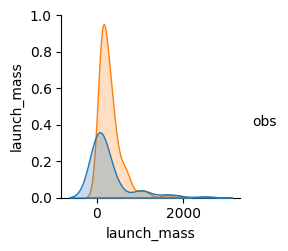

[1810/2000]: loss_d: 0.099, loss_g: -0.521
[1820/2000]: loss_d: 0.194, loss_g: -0.639
[1830/2000]: loss_d: 0.066, loss_g: -0.426
[1840/2000]: loss_d: 0.138, loss_g: -0.526
[1850/2000]: loss_d: 0.103, loss_g: -0.517


2021.0


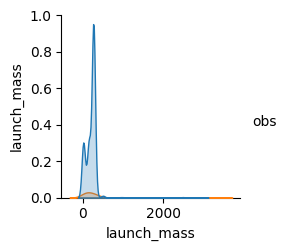

[1860/2000]: loss_d: 0.157, loss_g: -0.573
[1870/2000]: loss_d: 0.110, loss_g: -0.496
[1880/2000]: loss_d: 0.107, loss_g: -0.467
[1890/2000]: loss_d: 0.117, loss_g: -0.470
[1900/2000]: loss_d: 0.126, loss_g: -0.444


2021.0


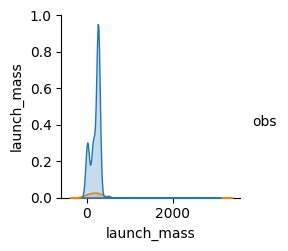

[1910/2000]: loss_d: 0.112, loss_g: -0.442
[1920/2000]: loss_d: 0.112, loss_g: -0.456
[1930/2000]: loss_d: 0.108, loss_g: -0.456
[1940/2000]: loss_d: 0.110, loss_g: -0.453
[1950/2000]: loss_d: 0.109, loss_g: -0.456


2021.0


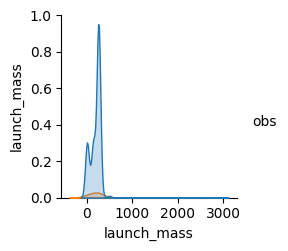

[1960/2000]: loss_d: 0.094, loss_g: -0.461
[1970/2000]: loss_d: 0.123, loss_g: -0.467
[1980/2000]: loss_d: 0.102, loss_g: -0.456
[1990/2000]: loss_d: 0.101, loss_g: -0.440


In [163]:
wgan_sats.train(n_epochs=N_EPOCHS)

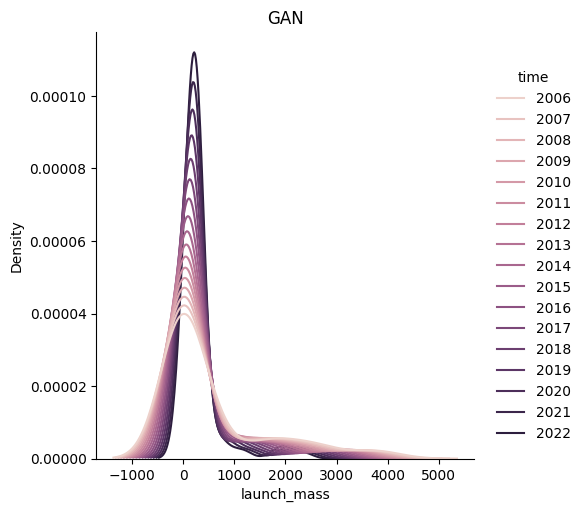

In [164]:

samples = wgan_sats.sample(time_periods=data.time.unique(), sample_size=100)

sns.displot(samples, x='launch_mass', hue='time', kind='kde')
plt.title('GAN')
plt.show()

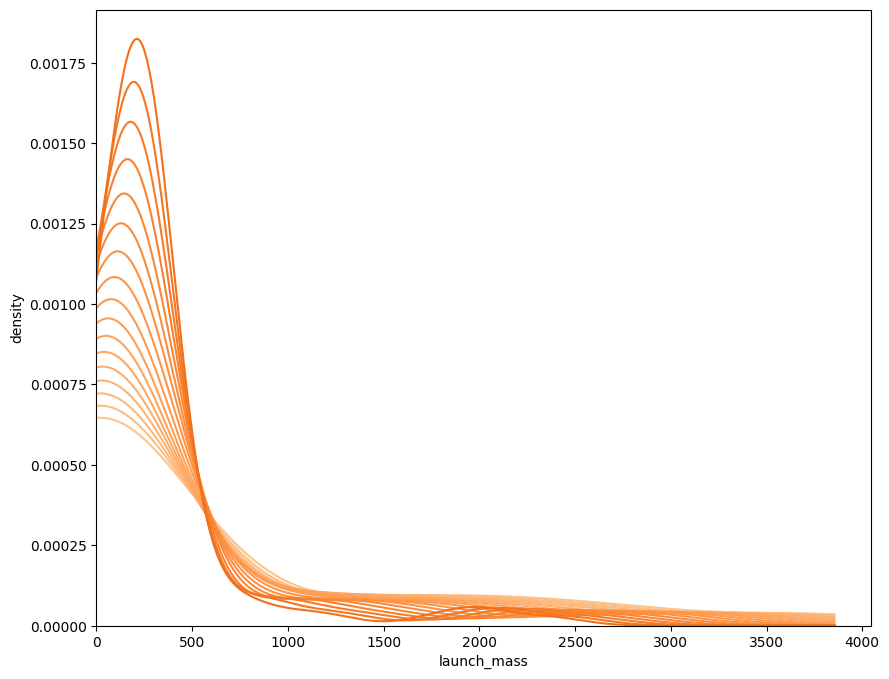

In [165]:
kde_wgan = get_kdes(samples, 'launch_mass', 'time', data.time.unique())
output_wgan = [kde_wgan[i].score_samples(grid_points.reshape(-1,1)) for i in data.time.unique()]

plt.figure(dpi=100, figsize=(10,8))

for n, o in zip( np.linspace(0.3 ,0.6 , data.time.nunique()), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)

plt.xlabel('launch_mass')
plt.ylabel('density');

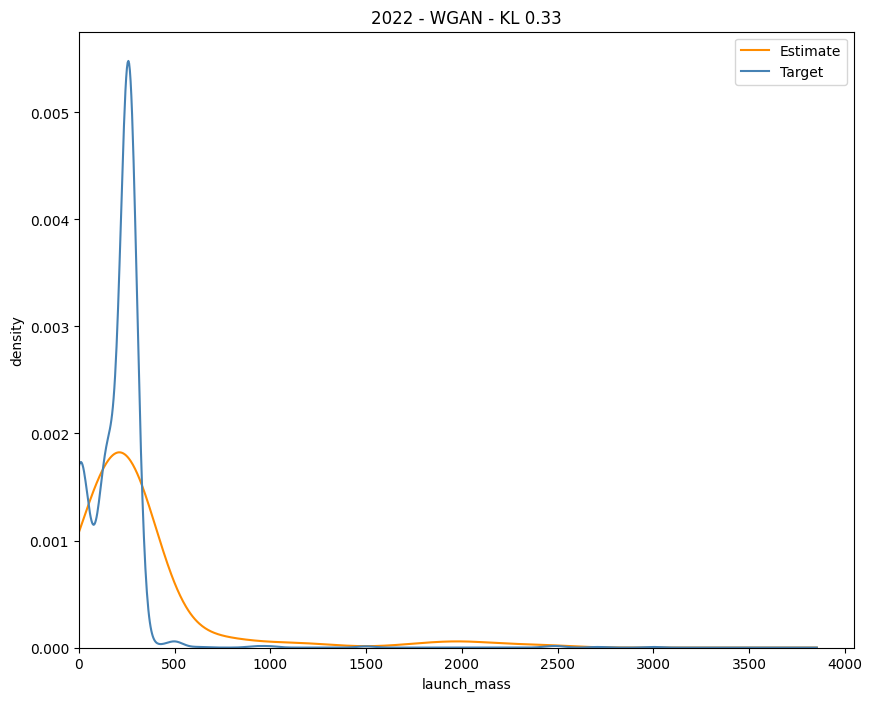

In [166]:
#kde_wgan = get_kdes(samples[samples.time==2022], 'launch_mass', 'time', [2022])
#output_wgan = kde_wgan[2022].score_samples(grid_points.reshape(-1,1))

KL_wgan = get_kl( np.exp(output_wgan[-1])[1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, np.exp(output_wgan[-1]), 'darkorange', label='Estimate')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - WGAN - KL {:.2f}'.format(KL_wgan))

plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()